# 海森堡 XXZ 模型
## 主程序 0： 基网络的搭建与训练，采用哈密顿变分拟设 (HVA)

In [12]:
import numpy as np
import mindspore as ms
from mindquantum import *
import matplotlib.pyplot as plt
from rich.progress import *

ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
np.random.seed(1)

def ham(qubit_num): # 根据海森堡 XXZ 模型，生成系统哈密顿量
    ham = QubitOperator(f'X{0} X{qubit_num-1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'X{i} X{i+1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'Y{i} Y{i+1}', 1)
    ham += QubitOperator(f'Y{0} Y{qubit_num-1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'Z{i} Z{i+1}', 2)
    ham += QubitOperator(f'Z{0} Z{qubit_num-1}', -1)
    return [Hamiltonian(ham)]

def net_work(qubit_num=4, layer_num=4): # 根据哈密顿拟设定义，搭建拟设线路
    circ = Circuit()
    for i in range(layer_num):
        for j in range(qubit_num-1):
            circ += Rxx(para_names[int(3 * i + 0)]).on([j + 1, j])
        circ += Rxx(para_names[int(3 * i + 0)]).on([qubit_num - 1, 0])
        for j in range(qubit_num-1):
            circ += Ryy(para_names[int(3 * i + 1)]).on([j + 1, j])
        circ += Ryy(para_names[int(3 * i + 1)]).on([qubit_num - 1, 0])
        for j in range(qubit_num-1):
            circ += Rzz(para_names[int(3 * i + 2)]).on([j + 1, j])
        circ += Rzz(para_names[int(3 * i + 2)]).on([qubit_num - 1, 0])
    return circ

qubit_num = 4
layer_num = qubit_num  # 网络层数设为和比特数相同
para_names = np.array(range(layer_num * 3 )).astype(str)
hamiltonian = ham(qubit_num) # 生成系统总的哈密顿量，此处是基网络的哈密顿量
base = net_work(qubit_num=qubit_num, layer_num=layer_num)

sample_num = 100 # 最后要对多次训练结果进行分析，设置采样次数

sim = Simulator('mqvector', base.n_qubits)
grad_ops = sim.get_expectation_with_grad(hamiltonian, base)

paras_list = [] # 参数保存
with Progress() as progress:
    task = progress.add_task("[red]Sampling", total=sample_num)
    for num in range(sample_num): # 采样多次
        net = MQAnsatzOnlyLayer(grad_ops)   # 搭建网络
        opti = ms.nn.Adam(net.trainable_params(), learning_rate=0.05)    # 优化器
        train_net = ms.nn.TrainOneStepCell(net, opti)  # 调用一次，就训练一次
        # print('\n初始期望值为：',train_net()[0])

        for i in range(200): # 训练 200 个回合，已足够收敛
            train_net()

        # print('最终期望值为!', train_net()[0])
        paras_list.append(net.weight.asnumpy()) # 保存收敛后的基网络参数
        progress.update(task, advance=1)

base_net_paras = np.array(paras_list)
print('\n收敛参数为：\n', base_net_paras.shape)

np.save('./src/XXZ_base_net_paras.npy', base_net_paras)  # 导出数据
print('\n导出完成啦!')

# a = np.load('./src/XXZ_base_net_paras.npy', allow_pickle=True) # 重新导入，以检验
# print('\n检验参数维度为：\n', a.shape)

Output()


收敛参数为：
 (100, 12)

导出完成啦!


## 主程序 1：采用结构迁移，不同参数迁移策略，在不同比特数下梯度方差的变化情况。

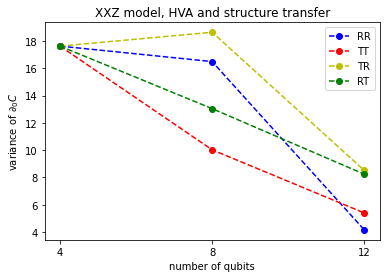

In [15]:
from mindquantum import *
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def ham(qubit_num): # 根据一维海森堡 XXZ 模型，生成系统哈密顿量
    ham = QubitOperator(f'X{0} X{qubit_num-1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'X{i} X{i+1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'Y{i} Y{i+1}', 1)
    ham += QubitOperator(f'Y{0} Y{qubit_num-1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'Z{i} Z{i+1}', 2)
    ham += QubitOperator(f'Z{0} Z{qubit_num-1}', -1)
    return [Hamiltonian(ham)]

def net_work(qubit_num=4, layer_num=1):
    circ = Circuit()
    for i in range(layer_num):
        for j in range(qubit_num-1):
            circ += Rxx(para_names[int(3 * i + 0)]).on([j + 1, j])
        circ += Rxx(para_names[int(3 * i + 0)]).on([qubit_num - 1, 0])
        for j in range(qubit_num-1):
            circ += Ryy(para_names[int(3 * i + 1)]).on([j + 1, j])
        circ += Ryy(para_names[int(3 * i + 1)]).on([qubit_num - 1, 0])
        for j in range(qubit_num-1):
            circ += Rzz(para_names[int(3 * i + 2)]).on([j + 1, j])
        circ += Rzz(para_names[int(3 * i + 2)]).on([qubit_num - 1, 0])
    return circ

def get_rr_var(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 rr 表示整个目标网络都是由随机参数层构成
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    avg_var = 0
    for i in range(sample_num):
        paras = np.random.rand(len(circuit.params_name))*2*np.pi
        avg_var += grad_ops(paras)[1][0,0,1].real**2 / sample_num
    return avg_var

def get_tt_var(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 tt 表示整个目标网络都是由最佳参数层构成
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    avg_var = 0
    for i in range(sample_num):
        paras = np.array([])
        for _ in range(int(circuit.n_qubits / 4)): # 因为之前设置层数和比特数相同，所以这里用比特数代替层数
            paras = np.append(paras, base_net_paras[i])
        avg_var += grad_ops(paras)[1][0,0,1].real**2 / sample_num
    return avg_var

def get_tr_var(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 tr 表示整个目标网络都是由最佳参数层和随机参数层交替构成
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    avg_var = 0
    for i in range(sample_num):
        paras = np.array([])
        for j in range(int(circuit.n_qubits / 4)): # 因为之前设置层数和比特数相同，所以这里用比特数代替层数
            if j % 2 == 0:
                paras = np.append(paras, base_net_paras[i])
            else:
                paras = np.append(paras, np.random.rand(3 * 4) * 2 * np.pi)
        avg_var += grad_ops(paras)[1][0,0,1].real**2 / sample_num
    return avg_var

def get_rt_var(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 rt 表示整个目标网络都是由随机参数层和最佳参数层交替构成
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    avg_var = 0
    for i in range(sample_num):
        paras = np.array([])
        for j in range(int(circuit.n_qubits / 4)): # 因为之前设置层数和比特数相同，所以这里用比特数代替层数
            if j % 2 == 1:
                paras = np.append(paras, base_net_paras[i])
            else:
                paras = np.append(paras, np.random.rand(3 * 4) * 2 * np.pi)
        avg_var += grad_ops(paras)[1][0,0,1].real**2 / sample_num
    return avg_var

sample_num = 100
base_net_paras = np.load('./src/XXZ_base_net_paras.npy', allow_pickle=True)

# 先计算 qubit_num = 4 的情况

hamiltonian = ham(qubit_num=4)
para_names = np.array(range(4 * 3 )).astype(str)
ansatz = net_work(qubit_num=4, layer_num=4)
base_avg_var = get_rr_var(ansatz, hamiltonian, sample_num=sample_num)

avg_rr_var_list = [base_avg_var]
avg_tt_var_list = [base_avg_var]
avg_rt_var_list = [base_avg_var]
avg_tr_var_list = [base_avg_var]

for qubit_num in [8, 12]: # 比特范围为 4 到 12
    layer_num = qubit_num
    hamiltonian = ham(qubit_num)
    para_names = np.array(range(layer_num * 3 )).astype(str)
    ansatz = net_work(qubit_num=qubit_num, layer_num=layer_num)

    avg_var = get_rr_var(ansatz, hamiltonian, sample_num=sample_num)
    avg_rr_var_list.append(avg_var)

    avg_var = get_tt_var(ansatz, hamiltonian, sample_num=sample_num)
    avg_tt_var_list.append(avg_var)

    avg_var = get_tr_var(ansatz, hamiltonian, sample_num=sample_num)
    avg_tr_var_list.append(avg_var)

    avg_var = get_rt_var(ansatz, hamiltonian, sample_num=sample_num)
    avg_rt_var_list.append(avg_var)


plt.figure()
plt.plot(avg_rr_var_list, label = 'RR', linestyle='--', marker='o', color='b') # 画出训练过程中，验证集分类准确度的变化情况
plt.plot(avg_tt_var_list, label = 'TT', linestyle='--', marker='o', color='r') # 画出训练过程中，验证集分类准确度的变化情况
plt.plot(avg_tr_var_list, label = 'TR', linestyle='--', marker='o', color='y') # 画出训练过程中，验证集分类准确度的变化情况
plt.plot(avg_rt_var_list, label = 'RT', linestyle='--', marker='o', color='g') # 画出训练过程中，验证集分类准确度的变化情况
plt.title('XXZ model, HVA and structure transfer', fontsize=12)
plt.legend()
plt.xlabel('number of qubits', fontsize=10)
plt.xticks(ticks=[0, 1, 2], labels=[4, 8, 12])
plt.ylabel(r'variance of $\partial_0C$ ', fontsize=10)
plt.savefig('./src/Fig3c.png')
plt.show()

## 主程序 2：采用结构迁移，不同参数迁移策略，在不同比特数下的正则化梯度范数变化情况。

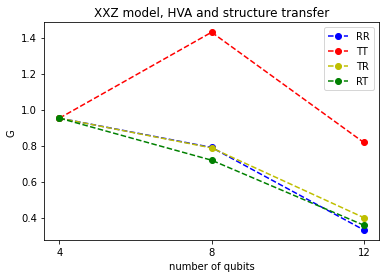

In [16]:
from mindquantum import *
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

def ham(qubit_num): # 根据一维海森堡 XXZ 模型，生成系统哈密顿量
    ham = QubitOperator(f'X{0} X{qubit_num-1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'X{i} X{i+1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'Y{i} Y{i+1}', 1)
    ham += QubitOperator(f'Y{0} Y{qubit_num-1}', -1)
    for i in range(qubit_num-1):
        ham += QubitOperator(f'Z{i} Z{i+1}', 2)
    ham += QubitOperator(f'Z{0} Z{qubit_num-1}', -1)
    return [Hamiltonian(ham)]

def net_work(qubit_num=4, layer_num=1):
    circ = Circuit()
    for i in range(layer_num):
        for j in range(qubit_num-1):
            circ += Rxx(para_names[int(3 * i + 0)]).on([j + 1, j])
        circ += Rxx(para_names[int(3 * i + 0)]).on([qubit_num - 1, 0])
        for j in range(qubit_num-1):
            circ += Ryy(para_names[int(3 * i + 1)]).on([j + 1, j])
        circ += Ryy(para_names[int(3 * i + 1)]).on([qubit_num - 1, 0])
        for j in range(qubit_num-1):
            circ += Rzz(para_names[int(3 * i + 2)]).on([j + 1, j])
        circ += Rzz(para_names[int(3 * i + 2)]).on([qubit_num - 1, 0])
    return circ


def get_rr_gra_norm(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 rr 表示整个目标网络都是由随机参数层构成
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    gra_num =len(circuit.params_name)
    avg_gra_norm = 0
    for i in range(sample_num):
        paras = np.random.rand(len(circuit.params_name))*2*np.pi
        gra_norm = 0
        for j in range(gra_num):
            gra_norm += grad_ops(paras)[1][0, 0, j].real**2
        gra_norm = np.sqrt(gra_norm) / gra_num
        avg_gra_norm += gra_norm / sample_num
    return avg_gra_norm

def get_tt_gra_norm(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 tt 表示整个目标网络都是由最佳参数层构成
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    gra_num =len(circuit.params_name)
    avg_gra_norm = 0
    for i in range(sample_num):
        paras = np.array([])
        for _ in range(int(circuit.n_qubits / 4)): # 因为之前设置层数和比特数相同，所以这里用比特数代替层数
            paras = np.append(paras, base_net_paras[i])
        gra_norm = 0
        for j in range(gra_num):
            gra_norm += grad_ops(paras)[1][0, 0, j].real**2
        gra_norm = np.sqrt(gra_norm) / gra_num
        avg_gra_norm += gra_norm / sample_num
    return avg_gra_norm

def get_tr_gra_norm(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 tr 表示整个目标网络都是由最佳参数层和随机参数层交替构成
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    gra_num =len(circuit.params_name)
    avg_gra_norm = 0
    for i in range(sample_num):
        paras = np.array([])
        for j in range(int(circuit.n_qubits / 4)): # 因为之前设置层数和比特数相同，所以这里用比特数代替层数
            if j % 2 == 0:
                paras = np.append(paras, base_net_paras[i])
            else:
                paras = np.append(paras, np.random.rand(3 * 4) * 2 * np.pi)
        gra_norm = 0
        for j in range(gra_num):
            gra_norm += grad_ops(paras)[1][0, 0, j].real**2
        gra_norm = np.sqrt(gra_norm) / gra_num
        avg_gra_norm += gra_norm / sample_num
    return avg_gra_norm

def get_rt_gra_norm(circuit,  hamiltonian, sample_num = 10):   # r 表示随机参数层  t 表示最佳参数层。 rt 表示整个目标网络都是由随机参数层和最佳参数层交替构成
    simulator = Simulator('mqvector', circuit.n_qubits)
    grad_ops = simulator.get_expectation_with_grad(hamiltonian, circuit)
    gra_num =len(circuit.params_name)
    avg_gra_norm = 0
    for i in range(sample_num):
        paras = np.array([])
        for j in range(int(circuit.n_qubits / 4)): # 因为之前设置层数和比特数相同，所以这里用比特数代替层数
            if j % 2 == 1:
                paras = np.append(paras, base_net_paras[i])
            else:
                paras = np.append(paras, np.random.rand(3 * 4) * 2 * np.pi)
        gra_norm = 0
        for j in range(gra_num):
            gra_norm += grad_ops(paras)[1][0, 0, j].real**2
        gra_norm = np.sqrt(gra_norm) / gra_num
        avg_gra_norm += gra_norm / sample_num
    return avg_gra_norm

sample_num = 100
base_net_paras = np.load('./src/XXZ_base_net_paras.npy', allow_pickle=True)

# 先计算 qubit_num = 4 的情况
hamiltonian = ham(qubit_num=4)
para_names = np.array(range(4 * 3 )).astype(str)
ansatz = net_work(qubit_num=4, layer_num=4)
base_avg_gra_norm = get_rr_gra_norm(ansatz, hamiltonian, sample_num=sample_num)

avg_rr_gra_norm_list = [base_avg_gra_norm]
avg_tt_gra_norm_list = [base_avg_gra_norm]
avg_rt_gra_norm_list = [base_avg_gra_norm]
avg_tr_gra_norm_list = [base_avg_gra_norm]

for qubit_num in [8, 12]: # 比特范围为 4 到 12
    layer_num = qubit_num
    hamiltonian = ham(qubit_num)
    para_names = np.array(range(layer_num * 3 )).astype(str)
    ansatz = net_work(qubit_num=qubit_num, layer_num=layer_num)

    avg_gra_norm = get_rr_gra_norm(ansatz, hamiltonian, sample_num=sample_num)
    avg_rr_gra_norm_list.append(avg_gra_norm)

    avg_gra_norm = get_tt_gra_norm(ansatz, hamiltonian, sample_num=sample_num)
    avg_tt_gra_norm_list.append(avg_gra_norm)

    avg_gra_norm = get_tr_gra_norm(ansatz, hamiltonian, sample_num=sample_num)
    avg_tr_gra_norm_list.append(avg_gra_norm)

    avg_gra_norm = get_rt_gra_norm(ansatz, hamiltonian, sample_num=sample_num)
    avg_rt_gra_norm_list.append(avg_gra_norm)

plt.figure()
plt.plot(avg_rr_gra_norm_list, label = 'RR', linestyle='--', marker='o', color='b') # 网络全部采用随机参数初始化层
plt.plot(avg_tt_gra_norm_list, label = 'TT', linestyle='--', marker='o', color='r') # 网络全部采用最佳参数初始化层
plt.plot(avg_tr_gra_norm_list, label = 'TR', linestyle='--', marker='o', color='y') # 网络采用最佳参数初始化层和随机参数初始化层交替
plt.plot(avg_rt_gra_norm_list, label = 'RT', linestyle='--', marker='o', color='g') # 网络采用随机参数初始化层和最佳参数初始化层交替
plt.title('XXZ model, HVA and structure transfer', fontsize=12)
plt.legend()
plt.xlabel('number of qubits', fontsize=10)
plt.xticks(ticks=[0, 1, 2], labels=[4, 8, 12])
plt.ylabel('G ', fontsize=10)
plt.savefig('./src/Fig3f.png')
plt.show()

In [17]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum')

Software,Version
mindquantum,0.9.0
System,Info
Python,3.9.7
OS,Linux x86_64
Memory,16.71 GB
CPU Max Thread,8
Date,Tue Oct 17 23:03:38 2023
